In [20]:
from sentence_transformers import losses, evaluation
import zipfile

import pandas as pd
from sklearn import model_selection
from datasets import Dataset

from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.similarity_functions import SimilarityFunction
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

In [17]:
import zipfile
import pandas as pd
from sklearn import model_selection

with zipfile.ZipFile("/kaggle/input/quora-question-pairs/train.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("./train/")

# Load and clean data
df = pd.read_csv("/kaggle/working/train/train.csv").dropna()
df = df.rename(columns={'is_duplicate': 'label'})[['question1', 'question2', 'label']]

# Split into train+val and test (80%/20%)
train_val, test = model_selection.train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

# Split train+val into train and val (75%/25% of train_val)
train, val = model_selection.train_test_split(
    train_val, test_size=0.25, random_state=42, stratify=train_val['label']
)

# Convert to Dataset objects
from datasets import Dataset
train_ds = Dataset.from_pandas(train.reset_index(drop=True))
val_ds = Dataset.from_pandas(val.reset_index(drop=True))
test_ds = Dataset.from_pandas(test.reset_index(drop=True))

In [18]:
import torch
from sklearn.metrics import f1_score
from tqdm import tqdm
import numpy as np

def evaluate_f1(model, dataset, threshold=0.5, is_cross_encoder=False, batch_size=128):
    q1, q2, labels = dataset['question1'], dataset['question2'], dataset['label']
    n_samples = len(labels)
    predictions = []
    
    if is_cross_encoder:
        from sentence_transformers import CrossEncoder
        if not isinstance(model, CrossEncoder):
            model = CrossEncoder(model)
        
        # Process in batches
        for i in tqdm(range(0, n_samples, batch_size), desc="Evaluating Cross-Encoder"):
            batch_q1 = q1[i:i+batch_size]
            batch_q2 = q2[i:i+batch_size]
            batch_scores = model.predict(list(zip(batch_q1, batch_q2)))
            batch_preds = (batch_scores >= threshold).astype(int)
            predictions.extend(batch_preds)
            
    else:
        # Process question1 and question2 separately in batches
        emb1_list, emb2_list = [], []
        
        # Encode question1 in batches
        for i in tqdm(range(0, n_samples, batch_size), desc="Encoding question1"):
            batch_q1 = q1[i:i+batch_size]
            emb1_batch = model.encode(batch_q1, convert_to_tensor=False, show_progress_bar=False)
            emb1_list.append(emb1_batch)
        
        # Encode question2 in batches
        for i in tqdm(range(0, n_samples, batch_size), desc="Encoding question2"):
            batch_q2 = q2[i:i+batch_size]
            emb2_batch = model.encode(batch_q2, convert_to_tensor=False, show_progress_bar=False)
            emb2_list.append(emb2_batch)
        
        # Concatenate all batches
        emb1 = np.concatenate(emb1_list, axis=0)
        emb2 = np.concatenate(emb2_list, axis=0)
        
        # Normalize embeddings for cosine similarity
        emb1_norm = emb1 / np.linalg.norm(emb1, axis=1, keepdims=True)
        emb2_norm = emb2 / np.linalg.norm(emb2, axis=1, keepdims=True)
        
        # Compute cosine similarity element-wise (much more memory efficient)
        cos_scores = np.sum(emb1_norm * emb2_norm, axis=1)
        scores = (cos_scores + 1) / 2  # Convert from [-1,1] to [0,1]
        predictions = (scores >= threshold).astype(int)
    
    return f1_score(labels, predictions)

In [19]:
config = {
    "model_path": "microsoft/xtremedistil-l6-h256-uncased",
    
    "learning_rate": 5e-4,
    "train_batch_size": 320,
    "eval_batch_size": 320,
    "epochs": 5,
    "warmup_ratio": 0.1,
    
    "output_dir": "."
}

In [9]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer(config["model_path"])
val_f1 = evaluate_f1(model, val_ds)
print(f"Benchmark F1-Score: {val_f1:.4f}")

Encoding question2: 100%|██████████| 632/632 [00:18<00:00, 34.51it/s]


Benchmark F1-Score: 0.5393


In [21]:
# Create a more memory-efficient evaluator
class F1Evaluator:
    def __init__(self, dataloader, threshold=0.5):
        self.dataloader = dataloader
        self.threshold = threshold
        
    def __call__(self, model, output_path=None, epoch=-1, steps=-1):
        all_labels = []
        all_predictions = []
        
        for batch in tqdm(self.dataloader, desc="Evaluating"):
            features, labels = batch
            emb1 = model.encode(features['question1'], convert_to_tensor=False)
            emb2 = model.encode(features['question2'], convert_to_tensor=False)
            
            # Compute cosine similarity
            emb1_norm = emb1 / np.linalg.norm(emb1, axis=1, keepdims=True)
            emb2_norm = emb2 / np.linalg.norm(emb2, axis=1, keepdims=True)
            cos_scores = np.sum(emb1_norm * emb2_norm, axis=1)
            scores = (cos_scores + 1) / 2
            
            predictions = (scores >= self.threshold).astype(int)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predictions)
        
        f1 = f1_score(all_labels, all_predictions)
        return f1

In [13]:
# Train with cosine similarity loss
train_loss = losses.CosineSimilarityLoss(model=model)

args = SentenceTransformerTrainingArguments(
    output_dir=config["output_dir"],
    
    num_train_epochs=config["epochs"],
    learning_rate=config["learning_rate"],
    per_device_train_batch_size=config["train_batch_size"],
    per_device_eval_batch_size=config["eval_batch_size"],
    
    warmup_ratio=config["warmup_ratio"],
    
    fp16=True,
    
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    
    report_to="none"
)

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    loss=train_loss,
)
trainer.train()

# Evaluate on test set
test_f1 = evaluate_f1(model, test_ds, batch_size=256)
print(f"CosineSimilarityLoss F1: {test_f1:.4f}")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss
1,0.194200,0.160368
2,0.137900,0.136674
3,0.122100,0.129623
4,0.104000,0.120330
5,0.095000,0.116566


Encoding question2: 100%|██████████| 316/316 [00:21<00:00, 14.85it/s]


CosineSimilarityLoss F1: 0.5985


In [14]:
contrastive_loss = losses.ContrastiveLoss(model=model)

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    loss=contrastive_loss,
)
trainer.train()

test_f1 = evaluate_f1(model, test_ds, batch_size=256)
print(f"ContrastiveLoss F1: {test_f1:.4f}")

Epoch,Training Loss,Validation Loss
1,0.012500,0.016360
2,0.011100,0.014149
3,0.009400,0.014080
4,0.007900,0.013596
5,0.007100,0.013501


Encoding question2: 100%|██████████| 316/316 [00:21<00:00, 14.94it/s]


ContrastiveLoss F1: 0.5466


In [15]:
# Filter only positive pairs for MNRL
pos_indices = [i for i, label in enumerate(train_ds['label']) if label == 1]
pos_train_ds = train_ds.select(pos_indices)

mnrl_loss = losses.MultipleNegativesRankingLoss(model=model)

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=pos_train_ds,
    eval_dataset=val_ds,
    loss=mnrl_loss,
)
trainer.train()

test_f1 = evaluate_f1(model, test_ds, batch_size=256)
print(f"MNRL F1: {test_f1:.4f}")

Epoch,Training Loss,Validation Loss
1,No log,1.906173
2,0.310300,1.739694
3,0.310300,1.684010
4,0.166900,1.647164
5,0.166900,1.636059


Encoding question2: 100%|██████████| 316/316 [00:21<00:00, 14.46it/s]


MNRL F1: 0.5530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l6-h256-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/242571 [00:00<?, ? examples/s]

Map:   0%|          | 0/80858 [00:00<?, ? examples/s]

Map:   0%|          | 0/80858 [00:00<?, ? examples/s]

/tmp/ipykernel_36/4179612746.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training cross-encoder model...


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.411400,0.382643,0.832013,0.829046,0.859106,0.829046
2,0.279100,0.299005,0.881088,0.881162,0.881023,0.881162
3,0.227600,0.301834,0.887084,0.886715,0.887732,0.886715
4,0.175300,0.296066,0.890856,0.890635,0.891178,0.890635
5,0.142000,0.317150,0.892995,0.892639,0.893643,0.892639



Evaluating on test set...


Test Results:
F1-Score: 0.8929
Accuracy: 0.8926
Precision: 0.8936
Recall: 0.8926

Detailed Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.92      0.90      0.91     51005
    Duplicate       0.84      0.87      0.86     29853

     accuracy                           0.89     80858
    macro avg       0.88      0.89      0.89     80858
 weighted avg       0.89      0.89      0.89     80858

Final F1-Score on test set: 0.8571

Sample predictions from test set:
Q1: Is the new TV show “Westworld” worth watching?
Q2: Is westworld worth watching?
True: Duplicate
Pred: Duplicate
Correct: True
--------------------------------------------------------------------------------
Q1: Is daily masturbation causes any hair fall?
Q2: Does excessive masturbation lead to hair loss?
True: Duplicate
Pred: Duplicate
Correct: True
--------------------------------------------------------------------------------
Q1: How do I study 7th grade?
Q2: I am in coll

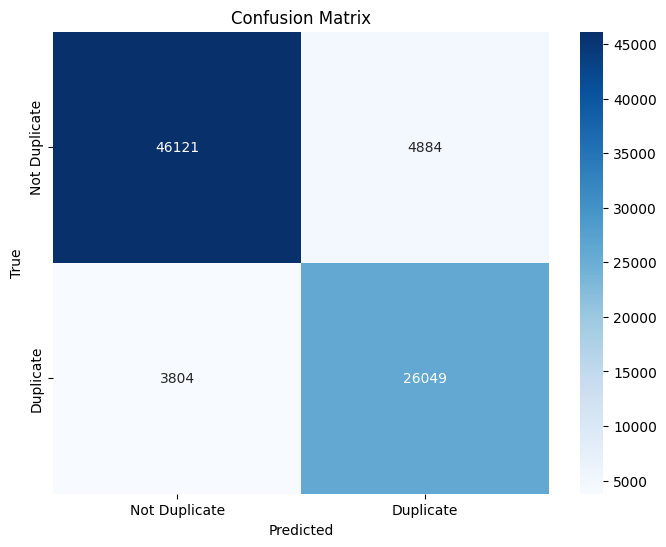

In [41]:
import zipfile
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from datasets import Dataset
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding


# Load tokenizer and model for sequence classification
tokenizer = AutoTokenizer.from_pretrained(config["model_path"])
model = AutoModelForSequenceClassification.from_pretrained(
    config["model_path"], num_labels=2
)

# Tokenization function
def tokenize_function(examples):
    texts = [(q1, q2) for q1, q2 in zip(examples["question1"], examples["question2"])]
    return tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=128,
        return_tensors="pt"
    )


# Tokenize datasets
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)
tokenized_test = test_ds.map(tokenize_function, batched=True)

# Format datasets for PyTorch
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_val = tokenized_val.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    
    return {
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

# Training arguments
training_args = TrainingArguments(
    output_dir=config["output_dir"],
    learning_rate=config["learning_rate"],
    per_device_train_batch_size=config["train_batch_size"],
    per_device_eval_batch_size=config["eval_batch_size"],
    num_train_epochs=config["epochs"],
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=config["warmup_ratio"],
    logging_dir='./logs',
    logging_steps=500,
    save_total_limit=2,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
print("Training cross-encoder model...")
trainer.train()

# Save the model
trainer.save_model()
tokenizer.save_pretrained(config["output_dir"])

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(tokenized_test)
print(f"Test Results:")
print(f"F1-Score: {test_results['eval_f1']:.4f}")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall: {test_results['eval_recall']:.4f}")

# Get detailed predictions on test set
test_predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_predictions.label_ids

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Not Duplicate', 'Duplicate']))

# Calculate and display F1-score
f1 = f1_score(true_labels, predicted_labels)
print(f"Final F1-Score on test set: {f1:.4f}")

# Example predictions
print("\nSample predictions from test set:")
sample_indices = np.random.choice(len(test), 5, replace=False)
for i in sample_indices:
    q1 = test.iloc[i]["question1"]
    q2 = test.iloc[i]["question2"]
    true_label = test.iloc[i]["label"]
    pred_label = predicted_labels[i]
    
    print(f"Q1: {q1}")
    print(f"Q2: {q2}")
    print(f"True: {'Duplicate' if true_label == 1 else 'Not Duplicate'}")
    print(f"Pred: {'Duplicate' if pred_label == 1 else 'Not Duplicate'}")
    print(f"Correct: {true_label == pred_label}")
    print("-" * 80)

# Additional analysis: Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Duplicate', 'Duplicate'],
            yticklabels=['Not Duplicate', 'Duplicate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()